
# Agentic  RAG sobre PDFs locales

Este notebook **lee PDFs de una carpeta** (recursivo), los **trocea**, crea **embeddings**, los guarda en **Chroma**, y permite preguntar con invoke`.

> Requisitos recomendados (mismo entorno):  
> `langchain>=0.2.5`, `langchain-community>=0.2.0`, `langchain-text-splitters>=0.2.0`, `langchain-openai>=0.1.0`  
> `chromadb>=0.5.0`, `tiktoken>=0.7.0`, `pypdf>=4`, `python-dotenv>=1.0.1`


## 1. Instalamos dependencias y librerias.

In [1]:
%pip install -U -q langchain>=0.2.5  langchain-community>=0.2.0  langchain-text-splitters>=0.2.0  chromadb>=0.5.0 tiktoken>=0.7.0  pypdf>=4  python-dotenv>=1.0.1 langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
from pathlib import Path
from typing import List

from dotenv import load_dotenv
load_dotenv()  # Carga variables de entorno (OPENAI_API_KEY, etc.)

# LangChain loaders, splitters, vectorstore, LLM/embeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

# Embeddings y modelo de chat (por defecto OpenAI)
from langchain_openai import OpenAIEmbeddings, ChatOpenAI ## XAvi

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings


# Utilidad
from tqdm import tqdm


## 2. Configuramos el entorno 

In [10]:

# 🛠️ Configuración
PDF_DIR = Path("./docs")             # <- Cambia a tu carpeta con PDFs
PERSIST_DIR = Path("./chroma_pdfs_gemini")  # Carpeta donde se guardará Chroma
PERSIST_DIR.mkdir(parents=True, exist_ok=True)

CHUNK_SIZE = 800
CHUNK_OVERLAP = 120
TOP_K = 4

# Modelos (ajusta si quieres otros)
EMBEDDING_MODEL = "models/text-embedding-004"
CHAT_MODEL = "gemini-2.5-flash"

# Verificar clave
assert os.getenv("OPENAI_API_KEY"), "Falta OPENAI_API_KEY en variables de entorno o .env"
print(f"📁 Carpeta PDFs: {PDF_DIR.resolve()}")
print(f"🗂️ Persistencia Chroma: {PERSIST_DIR.resolve()}")


📁 Carpeta PDFs: C:\Trainings\GenIA_trainings\Training\docs
🗂️ Persistencia Chroma: C:\Trainings\GenIA_trainings\Training\chroma_pdfs_gemini


## 3. Cargamos los pdfs.

In [4]:

def load_pdfs_from_dir(directory: Path, recursive: bool = True):
    pattern = "**/*.pdf" if recursive else "*.pdf"
    pdf_paths = sorted([p for p in directory.glob(pattern) if p.is_file()])
    all_docs = []
    for pdf in tqdm(pdf_paths, desc="Cargando PDFs"):
        try:
            docs = PyPDFLoader(str(pdf)).load()
            # Añadimos metadatos mínimos útiles
            for d in docs:
                d.metadata = d.metadata or {}
                d.metadata["source"] = str(pdf.resolve())
            all_docs.extend(docs)
        except Exception as e:
            print(f"⚠️ Error leyendo {pdf}: {e}")
    print(f"📚 Documentos (páginas) cargados: {len(all_docs)}")
    return all_docs

raw_docs = load_pdfs_from_dir(PDF_DIR, recursive=True)


Cargando PDFs: 100%|██████████| 2/2 [00:17<00:00,  8.52s/it]

📚 Documentos (páginas) cargados: 221


## 4. Chunking.

In [5]:

splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    separators=["\n\n", "\n", " ", ""],
)
chunks = splitter.split_documents(raw_docs)
print(f" Chunks generados: {len(chunks)}")
chunks[:2]  # vista rápida


 Chunks generados: 501


[Document(metadata={'producer': 'PyPDF', 'creator': 'Google', 'creationdate': '', 'title': 'Generative AI Deployment and Monitoring.pptx', 'source': 'C:\\Trainings\\GenIA_trainings\\Training\\docs\\generative-ai-deployment-and-monitoring.pdf', 'total_pages': 98, 'page': 0, 'page_label': '1'}, page_content='Lava 600 - Primary\n#FF3621\nRGB (255 ,54, 33)\nC0, M91, Y93, K0\nNavy 800 - Primary\n#1B3139\nRGB (27, 49, 57)\nC86, M65, Y57, K56\nMaroon 600\n#98102A\nRGB (152, 16, 42)\nC26, M100, Y84, K24\nYellow 600\n#FFAB00\nRGB (255, 171, 0)\nC0, M38, Y100, K0\nGreen 600\n#00A972\nRGB (0, 169, 114)\nC81, M6, Y74, K0\nBlue 600\n#2272B4\nRGB (34, 114,1 80)\nC86, M52, Y4, K0\nGray - Navigation\n#303F47\nRGB (48, 63, 71)\nC79, M62, Y54, K44\nGray – Text\n#5A6F77\nRGB (90, 111, 119)\nC68, M47, Y44, K14\nGray – Lines\n#DCE0E2\nRGB (220, 224, 226)\nC12, M7, Y8, K0\nPrimary palette\nSecondary palette\nOat Medium\n#EEEDE9\nRGB (238, 237, 233)\nC6, M4, Y6, K0\nOat Light\n#F9F7F4\nRGB (249, ,247, 244)\n

## 5. Embeddigs

In [11]:

# embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL)# Xavi
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory=str(PERSIST_DIR),
)
retriever =vectorstore.as_retriever()
print(" Chroma persistido")


 Chroma persistido


## 6. Creamos la Tool (Retriever)

In [12]:
from langchain_core.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",#nombre
    "Busca y devuelve info acerca de tus documentos pdf.",#Descripcion
)


### 6.1  Testeo de la tool.

In [13]:
retriever_tool.invoke({"query": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?"})

'Lava 500\n#FF5F46\nRGB (255, 95, 70)\nC0, M78, Y79, K0\nNavy 900\n#0B2026\nRGB (11, 32, 38)\nC86, M67, Y61,  K71\n© Databricks 2025. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Iceberg, Iceberg, and the Apache \nIceberg logo are trademarks of the Apache Software Foundation.\nBatch Deployment\n● Batch processing generates predictions on a regular schedule and \nwrites the results out to persistent storage to be consumed downstream \n(i.e. ad-hoc BI).\n● Batch deployment is the simplest deployment strategy.\n● Ideal for cases when: \n○ Immediate predictions is not necessary\n○ Predictions can be made in batch fashion\n○ Number/volume of (new) records/observations to predict is large\n○ Pace at which input/records change or is received is > 30 mins\n\nLava 500\n#FF5F46\nRGB (255, 95, 70)\nC0, M78, Y79, K0\nNavy 900\n#0B2026\nRGB (11, 32, 38)\nC86, M67, Y61,  K71\n© Databricks 2025. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Icebe

## 7. Creamos el nodo que nos dira si responde o va a la tool retrieve.

In [14]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
response_model = ChatGoogleGenerativeAI(model=CHAT_MODEL, temperature=0)

def genera_query_o_responde(state: MessagesState):
    """Llama al modelo para generar una respuesta basada en el estado actual.
      Dada la pregunta, decidirá si recupera información usando la herramienta de recuperación o simplemente responde al usuario."""
   
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

### 7.1 Lo probamos con una pregunta aleatoria

In [15]:
input = {"messages": [{"role": "user", "content": "¿Cuanto vale una cortina?"}]}
respuesta= genera_query_o_responde(input)
print (respuesta)

{'messages': [AIMessage(content=[{'type': 'text', 'text': 'Lo siento, no tengo la capacidad de buscar el precio de una cortina. Mi función es buscar y devolver información de tus documentos PDF.', 'extras': {'signature': 'CsYDAdHtim+SjUbvfXstAtXtLE/wEu+jirCGb4JErfl5qz7xYWacT2E4JnCLROFnzIMbH+CNN+vUoKZrNuJd6klFjCxuOXhMbB0r3otFkCMjRU0qQ6OZ83dxvFrkeScLq8QGqmW1Z8rB31PVdqybyD3qxDZzQ6+mu0ZOs5Si1Guo0KlHVj2izKyJE7hFHfMbj+jAopkdfnpUFwiaOjkBSIt92rh3o29SQP27NCjAjLzovYNghhM7qrE5TbKLIo/Vpc+mr1d/MUPMPa+lyQXfLk49+gfZEiM6JGG8AtiODDhldtK+wL6nelejo6UitO5AZ+A/vHkpYh7CHwChoLE3wwAMxYM9l1xvqHZNG6RZsJ+HOskH0/qUTTMEcxkVZfAtNsRwGgE8XZ2fNJ3fuqdjZJ5OixQ92augCH6qQfGQAReLqKacYVERITl8ZsCupnA97M0+yDmbpZMIW1E04mBc28zW/ut+KHX7FYZX9cZH5BQD/C9a5+pc/rIPehPvwyfw8dUfVmaw+wUONRDR9rr7+vnNIA9YQWJcc/C8UECrUhX/GiE0x3l14FqicDQdqqDYcm487YsgnxBTo4/UnE9c78F8ikHWclnFQw=='}}], additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash'

In [16]:
respuesta["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': 'Lo siento, no tengo la capacidad de buscar el precio de una cortina. Mi función es buscar y devolver información de tus documentos PDF.', 'extras': {'signature': 'CsYDAdHtim+SjUbvfXstAtXtLE/wEu+jirCGb4JErfl5qz7xYWacT2E4JnCLROFnzIMbH+CNN+vUoKZrNuJd6klFjCxuOXhMbB0r3otFkCMjRU0qQ6OZ83dxvFrkeScLq8QGqmW1Z8rB31PVdqybyD3qxDZzQ6+mu0ZOs5Si1Guo0KlHVj2izKyJE7hFHfMbj+jAopkdfnpUFwiaOjkBSIt92rh3o29SQP27NCjAjLzovYNghhM7qrE5TbKLIo/Vpc+mr1d/MUPMPa+lyQXfLk49+gfZEiM6JGG8AtiODDhldtK+wL6nelejo6UitO5AZ+A/vHkpYh7CHwChoLE3wwAMxYM9l1xvqHZNG6RZsJ+HOskH0/qUTTMEcxkVZfAtNsRwGgE8XZ2fNJ3fuqdjZJ5OixQ92augCH6qQfGQAReLqKacYVERITl8ZsCupnA97M0+yDmbpZMIW1E04mBc28zW/ut+KHX7FYZX9cZH5BQD/C9a5+pc/rIPehPvwyfw8dUfVmaw+wUONRDR9rr7+vnNIA9YQWJcc/C8UECrUhX/GiE0x3l14FqicDQdqqDYcm487YsgnxBTo4/UnE9c78F8ikHWclnFQw=='}}]


### 7.2  Hacer una pregunta que requiera una busqueda semantica

In [17]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?",
            #"content": "¿Que es un  batch?",
        }
    ]
}
genera_query_o_responde(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (fac8a701-7d2f-4157-be40-4d9e88f221d3)
 Call ID: fac8a701-7d2f-4157-be40-4d9e88f221d3
  Args:
    query: ¿Que es un deployment tipo batch?


## 8. Creamos la funcion y el prompt para comprobar si los documentos/contexto recuperado es relevante a la pregunta.

In [19]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \n "
    "Aquí tienes el documento recuperado: \n\n {context} \n\n"
    "Aquí tienes la pregunta del usuario: {question} \n"
    "Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \n"
    "Da una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta."

)


class GradeDocuments(BaseModel):
    """Califica los documentos utilizando una puntuación binaria para comprobar su relevancia"""

    binary_score: str = Field(
        description="Puntuación : 'si' si es relevante, o 'no' si no lo es"
    )


grader_model = ChatGoogleGenerativeAI(model=CHAT_MODEL, temperature=0)


def grade_documents(state: MessagesState,
) -> Literal["genera_respuesta", "rescribir_question"]:
    
    print("grade_documents")
    """Determina si los documentos recuperados son relevantes para la pregunta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print ("score :", score)
    if score == "si":
        return "genera_respuesta"
    else:
        return "rescribir_question"

### 8.1 Comprobamos con una respuesta irrelevante

In [20]:
#simulamos la respuesta de la tool mediante mensajes
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que es un deployment batch?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Que es un deployment batch?"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}


grade_documents(input)

grade_documents
score : no


'rescribir_question'

### 8.2 Coomprobar que el documento/respuesta relevante lo clasifica como tal

In [21]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
               
                "content": "¿Que es un deployment batch en el documento?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Que es un deployment batch en el documento?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "El contexto proporcionado hace referencia a 'batch deployment' (despliegue por lotes) en el documento, pero no ofrece una definición explícita de qué es 'batch'. Sin embargo, se menciona que uno de los objetivos de aprendizaje es describir el despliegue en batch y sus escenarios de uso, así como identificar las ventajas y desventajas de desplegar un modelo mediante procesamiento por lotes, y discutir un flujo de trabajo típico para este tipo de despliegue en Databricks.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

grade_documents
score : si


'genera_respuesta'

## 9. Creamos el nodo de rescribir la pregunta si no es lo suficientemente clara.

5.1 Crear el nodo de reesctirura de la pregunta

In [22]:
REWRITE_PROMPT = (
    "Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.\n"
    "Pregunta original:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:"
)


def rescribir_question(state: MessagesState):
    """Rescribe/Mejora la pregunta original del usuario."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

### 8.3. Probamos  la función de rescribir la pregunta.

In [23]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que es batch?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Que es batch?"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},#respuesta absurda
        ]
    )
}

response = rescribir_question(input)
print(response["messages"][-1]["content"])

La pregunta original "¿Qué es batch?" es demasiado ambigua debido a que la palabra "batch" tiene múltiples significados dependiendo del contexto (informática, producción, química, etc.). La intención profunda es, probablemente, obtener una definición o explicación de "batch" en un contexto específico que el usuario tiene en mente, pero que no ha explicitado.

Para hacerla más clara, precisa y fácil de entender, necesitamos añadir contexto o pedir al usuario que lo especifique.

Aquí tienes varias opciones, dependiendo del contexto más probable o de cómo quieras guiar al usuario:

**Opción 1 (La más completa, pidiendo contexto):**

> "Para poder responder con precisión, ¿podrías especificar el contexto en el que te refieres a 'batch'? Por ejemplo, ¿estás preguntando sobre:
>
> *   El concepto de **procesamiento por lotes (batch processing)** en informática?
> *   Los **archivos batch (.bat o .cmd)** en sistemas operativos?
> *   El significado general de **'un lote' o 'una tanda'** de a

## 10. Generamos la Respuesta.

### 10.1. Construimos el nodo generate_answer.
Si superamos las comprobaciones del evaluador (grader), podemos generar la respuesta final basándonos en la pregunta original y el contexto recuperado

In [24]:
GENERATE_PROMPT = (
    "Eres un asistente para tareas de preguntas y respuestas. "
    "Utiliza los siguientes fragmentos de contexto recuperado para responder a la pregunta. "
    "Si no sabes la respuesta, simplemente indica que no la sabes. "
    "Utiliza un máximo de tres frases y mantén la respuesta concisa.\n"
    "Pregunta: {question} \n"
    "Contexto: {context}"
)



def genera_respuesta(state: MessagesState):
    """Genera la respuesta."""
    print("genera_respuesta")
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### 10.2. Try it out.

In [26]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Qué significa el término 'batch deployment en databricks' y en qué contextos se utiliza?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Qué significa el término 'batch deployment en databriccks' y en qué contextos se utiliza?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "El contexto proporcionado hace referencia a 'batch deployment' (despliegue por lotes) en el documento, pero no ofrece una definición explícita de qué es 'batch'. Sin embargo, se menciona que uno de los objetivos de aprendizaje es describir el despliegue en batch y sus escenarios de uso, así como identificar las ventajas y desventajas de desplegar un modelo mediante procesamiento por lotes, y discutir un flujo de trabajo típico para este tipo de despliegue en Databricks",
                "tool_call_id": "1",
            },
        ]
    )
}

response = genera_respuesta(input)
response["messages"][-1].pretty_print()

genera_respuesta
================================== Ai Message ==================================

El contexto proporcionado menciona el término 'batch deployment' (despliegue por lotes) y que uno de los objetivos de aprendizaje es describirlo junto con sus escenarios de uso. Sin embargo, el contexto no ofrece una definición explícita de qué significa 'batch deployment'. Tampoco detalla los contextos específicos en los que se utiliza, más allá de indicar que se discutirán sus ventajas, desventajas y un flujo de trabajo típico en Databricks.


## 11. Configurar el grafo.
### 11.1. Importamos los elementos necesarios para construir el grafo

In [ ]:
#Hasta aqui ya tenemos todo el procesamiento y necesitamos 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### 11.2. Ensamblamos el workflow
#### 11.2.1 Añadimos los nodos
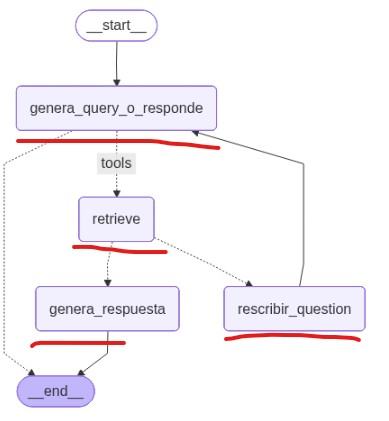

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node(genera_query_o_responde)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rescribir_question)
workflow.add_node(genera_respuesta)

#### 11.2.2 Añadimos las aristas
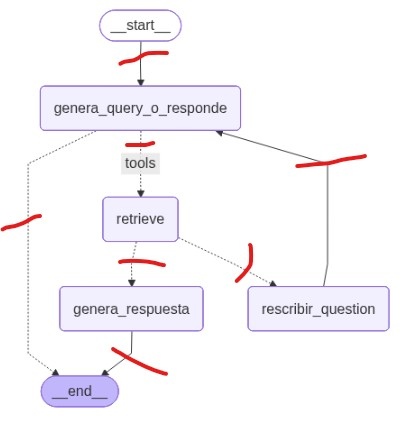

In [ ]:
workflow.add_edge(START, "genera_query_o_responde")

workflow.add_conditional_edges(
    "genera_query_o_responde",
    # Evalúa la decisión del LLM (llama a la herramienta retriever_tool o responde al usuario)
    tools_condition,
    {
        # Traduce las salidas de la condición a nodos dentro de nuestro grafo
        "tools": "retrieve",
        END: END,
    },
)

#
workflow.add_conditional_edges(
    "retrieve",
    # Evalúa la decisión del agente con la funcion de condicion
    grade_documents,  
)

workflow.add_edge("genera_respuesta", END)

workflow.add_edge("rescribir_question", "genera_query_o_responde")


### 11.3. Compilamos el Grafo

In [ ]:
graph = workflow.compile()

### 11.4. Pintamos el Grafo

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### 11.5. Ver como funciona el grafo.

In [ ]:
from pprint import pprint  

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                #"content": "¿Qué significa el término 'batch' y en qué contextos se utiliza?",
                "content": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?"
            }
        ]
    }
):
    for node, update in chunk.items():
        print(f"📘 Update from node: {node}")
        print("-" * 40)

        messages = update.get("messages", [])
      
        last_msg = messages[-1]

        try:
            if isinstance(last_msg, dict):
                if "content" in last_msg:
                    print("📝 Contenido textual:")
                    print(last_msg["content"])
                elif "tool_calls" in last_msg:
                    print("🔧 Llamada a función:")
                    pprint(last_msg["tool_calls"])
                else:
                    print("🕵️ Mensaje dict sin content/tool_calls:")
                    pprint(last_msg)
            elif hasattr(last_msg, "content"):
                print("📝 Contenido desde objeto:")
                print(last_msg.content)
            else:
                print("🕵️ Mensaje desconocido:")
                pprint(last_msg)

        except Exception as e:
            print("❌ Error leyendo el mensaje:", str(e))
            pprint(last_msg)

        print("-" * 40 + "\n")



### 11.6 Hacer una ejecución del grafo

In [ ]:
input = {
    "messages": [
        {
            "role": "user",
            # "content": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que es un deployment tipo batch?",
             "content": "Busca en la informacion proporcionada la pregunta que hace el usuario y no inventes¿Que són los  flavours de MLFlow?",
        }
    ]
}
from IPython.display import display, Markdown

display(Markdown(graph.invoke(input)["messages"][-1].content))
